In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import entropy
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin_min
import gc
import time
import os

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
!pip cache purge
!pip install --no-cache-dir sdv

Files removed: 0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 310.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 252.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.8/73.8 kB 265.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.4/193.4 kB 322.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 349.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 277.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 366.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 312.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 325.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 339.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [ ]:
from sdv.single_table import TVAESynthesizer
from sdv.metadata import Metadata

In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.utils import resample
import transformers
import re
import traceback
import random

In [ ]:
import transformers
print(transformers.__version__)

4.51.3


Prepare August Data

In [ ]:
dfaugust = pd.read_csv("df_augustweek2.csv")
dfaugust.head()
dforiginal=dfaugust.copy()

,Date,Duration,Src_Port,Dest_Port,Protocol,TOS,Packets,Bytes,Label,U,A,P,R,S,F
0,2016-08-08 08:24:59,0.000,42998,8194,6,0,1,44,scan44,0,0,0,0,1,0
1,2016-08-08 08:25:21,0.000,64677,3389,6,0,1,44,scan44,0,0,0,0,1,0
2,2016-08-08 00:14:31,0.000,37777,17,17,40,1,28,background,0,1,0,0,0,0
3,2016-08-08 08:24:13,0.000,35796,3306,6,0,1,44,scan44,0,0,0,0,1,0
4,2016-08-08 00:23:21,0.592,25,60939,6,0,5,564,anomaly-spam,0,1,1,0,1,1


In [ ]:
def map_classes(label):
    label = label.lower()
    if label.startswith('background'):
        return 0
    elif label.startswith('dos'):
        return 1
    elif label.startswith('nerisbotnet'):
        return 2
    elif label.startswith('scan44'):
        return 3
    elif label.startswith('anomaly-spam'):
        return 4

# Apply the mapping function to the 'Label' column
dfaugust['Class'] = dfaugust['Label'].apply(map_classes)
dfaugust['Class'] = dfaugust['Class'].astype(int)

In [ ]:
def map_labels(label):
    label = label.lower()
    if label.startswith('background'):
        return 'Benign'
    elif label.startswith('dos'):
        return 'DoS'
    elif label.startswith('nerisbotnet'):
        return 'Botnet'
    elif label.startswith('scan44'):
        return 'Scan44'
    elif label.startswith('anomaly-spam'):
        return 'Spam'

# Apply the mapping function to the 'Label' column
dfaugust['Label'] = dfaugust['Label'].apply(map_labels)

In [ ]:
dfaugust.Label.value_counts()

,count
Label,
Benign,30000
Scan44,17500
Spam,17500
Botnet,17500
DoS,17500


In [ ]:
dfbefore=dfaugust.copy()

In [ ]:
dfaugust.Class.value_counts()

,count
Class,
0,30000
3,17500
4,17500
2,17500
1,17500


In [ ]:
#reduce samples of minority class
spam_reduced_august = dfaugust[dfaugust.Label == "Spam"].sample(n=2000, random_state=42)
botnet_reduced_august = dfaugust[dfaugust.Label== "Botnet"].sample(n=2000, random_state=42)
dfaugust = dfaugust[~dfaugust.Label.isin(["Spam", "Botnet"])]
dfaugust= pd.concat([spam_reduced_august, botnet_reduced_august, dfaugust])
dfaugust.Label.value_counts()

,count
Label,
Benign,30000
DoS,17500
Scan44,17500
Spam,2000
Botnet,2000


In [ ]:
dfaugust.Label.value_counts()

,count
Label,
Benign,30000
DoS,17500
Scan44,17500
Spam,2000
Botnet,2000


In [ ]:
dfaugust = dfaugust.drop(columns=['Date', 'Label'])

In [ ]:
print(dfaugust.columns)

Index(['Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS', 'Packets',
       'Bytes', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')


In [ ]:
dforiginal=dfaugust.copy()

In [ ]:
botnet_orig = dfaugust[dfaugust.Class == 2]
spam_orig = dfaugust[dfaugust.Class == 4]

Split Train/Test

In [ ]:
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix

In [ ]:
clf_name_mlp = 'MLP'
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,100))

In [ ]:
clf_name_xgb = 'XGBoost'
xgb_classifier = xgb.XGBClassifier(max_depth=5, objective='multi:softprob', n_estimators=1000, num_classes=5)

In [ ]:
# fit algorithm to data
def fit_algo(algo, train_x, train_y):

    model = algo.fit(train_x, train_y)
    gc.collect()
    return model

def train_and_test(clf_name, clf, results, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model = fit_algo(clf, X_train, y_train)
    train_time = time.time() - start_time

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    f1 = f1_score(y_test, y_pred, average=None)
    f1_avg = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Calculate FPR and FNR for each class
    class_fpr = []
    class_fnr = []

    for i in range(conf_matrix.shape[0]):
        tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))  # sum of all non-i cells
        fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]  # sum of i-th column, excluding diagonal
        fn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]  # sum of i-th row, excluding diagonal
        tp = conf_matrix[i, i]  # i-th diagonal element

        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # Avoid division by zero
        fnr = fn / (fn + tp) if (fn + tp) != 0 else 0  # Avoid division by zero

        class_fpr.append(fpr)
        class_fnr.append(fnr)

    # Overall FPR and FNR (averaging across classes)
    avg_fpr = np.mean(class_fpr)
    avg_fnr = np.mean(class_fnr)

    return f1, f1_avg, train_time, conf_matrix, class_fpr, class_fnr, avg_fpr, avg_fnr

def preprocess_data(df):
    df_copy = df.copy()

    X = df_copy.drop('Class', axis=1)
    y = df_copy['Class']

    X = X.apply(pd.to_numeric, errors='coerce')

    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(X.mean(), inplace=True)

    # Double-check that no NaN values remain
    if X.isnull().any().any():
        print("Warning: NaNs detected in data after preprocessing. Check data sources or methods.")
        X.fillna(0, inplace=True)  # Fallback option: replace any remaining NaNs with 0

    return X.values, y.values

# Preprocess data
X_august, y_august = preprocess_data(dfaugust)


In [ ]:
dfbotnet = dfbefore[dfbefore.Class == 2]
dfspam = dfbefore[dfbefore.Class == 4]

In [ ]:
import threading
import psutil
import os
import time
import subprocess
import torch
from sdv.metadata import Metadata


def monitor_gpu(interval=5, duration=30):
    print("Live GPU Monitoring Started...\n")
    for _ in range(int(duration / interval)):
        output = subprocess.getoutput('nvidia-smi')
        print(output)
        print("-" * 80)
        time.sleep(interval)

def log_gpu_memory(tag):
    if torch.cuda.is_available():
      print(f"[{tag}] GPU: {torch.cuda.get_device_name(0)}")
      print(f"Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
      print(f"Memory Reserved : {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
      try:
          output = subprocess.check_output(
              ["nvidia-smi", "--query-gpu=utilization.gpu", "--format=csv,nounits,noheader"],
              encoding="utf-8"
          )
          util_percent = output.strip().split('\n')[0]
          print(f"GPU Utilization : {util_percent}%")
      except Exception as e:
          print(f"Could not fetch GPU utilization: {e}")

# Function to generate synthetic data
def generate_synthetic_botnet(df, multiplier):
  process = psutil.Process(os.getpid())

  # Start monitoring in a separate thread
  gpu_thread = threading.Thread(target=monitor_gpu, args=(5,30), daemon=True)
  gpu_thread.start()

  classes_to_keep = [2]

  filtered_df = df[df['Class'].isin(classes_to_keep)]

  filtered_df.Class.value_counts()

  n_samples = len(filtered_df) * multiplier
  #start time
  start_time = time.time()
  train_start_ram = process.memory_info().rss / 1024**2

  # Initialize TVAE model
  metadata = Metadata.detect_from_dataframe(
      data=filtered_df
  )
  synthesizer = TVAESynthesizer(
      metadata,
      epochs=3
  )

  # Fit the model on the filtered dataset
  synthesizer.fit(filtered_df)

  #end time
  end_time = time.time()
  train_end_ram = process.memory_info().rss / 1024**2
  print(f"Training Time for botnet class: {(end_time - start_time):.2f} seconds")
  print(f"RAM Usage after training for botnet class: {train_end_ram - train_start_ram:.2f} MB")
  print(f"CPU Usage for training: {psutil.cpu_percent(interval=1)}%")
  log_gpu_memory("Training")

  df['Class'] = df['Class'].astype(str)

  gen_start = time.time()
  gen_start_ram = process.memory_info().rss / 1024**2

  samples = synthesizer.sample(num_rows=n_samples)

  gen_end = time.time()
  gen_end_ram = process.memory_info().rss / 1024**2

  print(f"Generation Time for botnet: {gen_end - gen_start:.2f} seconds")
  print(f"RAM Usage for generation botnet: {gen_end_ram - gen_start_ram:.2f} MB")
  print(f"CPU Usage for generation: {psutil.cpu_percent(interval=1)}%")
  log_gpu_memory("Generation")

  return samples

synthetic_samples_botnet = generate_synthetic_botnet(dfbefore, 3)
X_synthetic = synthetic_samples_botnet.drop(columns=['Class']).values
y_synthetic = synthetic_samples_botnet['Class'].values


# Save CSV files
synthetic_samples_botnet.to_csv('TVAE_Generated_Botnet_August.csv', index=False)

print("Synthetic samples saved successfully!")

Live GPU Monitoring Started...

Mon May 26 06:03:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+---------------

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:123: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Mon May 26 06:03:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             45W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import threading
import psutil
import os
import time
import subprocess
import torch
from sdv.metadata import Metadata


def monitor_gpu(interval=5, duration=30):
    print("Live GPU Monitoring Started...\n")
    for _ in range(int(duration / interval)):
        output = subprocess.getoutput('nvidia-smi')
        print(output)
        print("-" * 80)
        time.sleep(interval)

def log_gpu_memory(tag):
    if torch.cuda.is_available():
      print(f"[{tag}] GPU: {torch.cuda.get_device_name(0)}")
      print(f"Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
      print(f"Memory Reserved : {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
      try:
          output = subprocess.check_output(
              ["nvidia-smi", "--query-gpu=utilization.gpu", "--format=csv,nounits,noheader"],
              encoding="utf-8"
          )
          util_percent = output.strip().split('\n')[0]
          print(f"GPU Utilization : {util_percent}%")
      except Exception as e:
          print(f"Could not fetch GPU utilization: {e}")

# Function to generate synthetic data
def generate_synthetic_spam(df, multiplier):
  process = psutil.Process(os.getpid())

  # Start monitoring in a separate thread
  gpu_thread = threading.Thread(target=monitor_gpu, args=(5,30), daemon=True)
  gpu_thread.start()

  classes_to_keep = [4]

  filtered_df = df[df['Class'].isin(classes_to_keep)]

  filtered_df.Class.value_counts()

  n_samples = len(filtered_df) * multiplier
  #start time
  start_time = time.time()
  train_start_ram = process.memory_info().rss / 1024**2

  # Initialize TVAE model
  metadata = Metadata.detect_from_dataframe(
      data=filtered_df
  )
  synthesizer = TVAESynthesizer(
      metadata,
      epochs=3
  )

  # Fit the model on the filtered dataset
  synthesizer.fit(filtered_df)

  #end time
  end_time = time.time()
  train_end_ram = process.memory_info().rss / 1024**2
  print(f"Training Time for spam class: {(end_time - start_time):.2f} seconds")
  print(f"RAM Usage after training for spam class: {train_end_ram - train_start_ram:.2f} MB")
  print(f"CPU Usage for training: {psutil.cpu_percent(interval=1)}%")
  log_gpu_memory("Training")

  df['Class'] = df['Class'].astype(str)

  gen_start = time.time()
  gen_start_ram = process.memory_info().rss / 1024**2

  samples = synthesizer.sample(num_rows=n_samples)

  gen_end = time.time()
  gen_end_ram = process.memory_info().rss / 1024**2

  print(f"Generation Time for spam: {gen_end - gen_start:.2f} seconds")
  print(f"RAM Usage for generation spam: {gen_end_ram - gen_start_ram:.2f} MB")
  print(f"CPU Usage for generation: {psutil.cpu_percent(interval=1)}%")
  log_gpu_memory("Generation")

  return samples

synthetic_samples_spam = generate_synthetic_spam(dfbefore, 3)
X_synthetic_spam = synthetic_samples_spam.drop(columns=['Class']).values
y_synthetic_spam = synthetic_samples_spam['Class'].values


# Save CSV files
synthetic_samples_spam.to_csv('TVAE_Generated_Spam_August.csv', index=False)

print("Synthetic samples saved successfully!")

Live GPU Monitoring Started...

Mon May 26 06:08:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             50W /  400W |     565MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+---------------

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:123: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Mon May 26 06:08:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             50W /  400W |     565MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
botnet_gen = pd.read_csv("/content/TVAE_Generated_Botnet_August.csv")
spam_gen = pd.read_csv("/content/TVAE_Generated_Spam_August.csv")

In [ ]:
botnet_gen.drop(columns=['Date', 'Label'], inplace=True)
spam_gen.drop(columns=['Date', 'Label'], inplace=True)

In [ ]:
print(botnet_gen.columns)
print(spam_gen.columns)

Index(['Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS', 'Packets',
       'Bytes', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')
Index(['Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS', 'Packets',
       'Bytes', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')


In [ ]:
print(botnet_gen.shape)
print(spam_gen.shape)

(52500, 14)
(52500, 14)


In [ ]:
print(botnet_gen.columns)
print(spam_gen.columns)

Index(['Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS', 'Packets',
       'Bytes', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')
Index(['Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS', 'Packets',
       'Bytes', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')


JSD

In [ ]:
from scipy.spatial.distance import jensenshannon

selected_features = ['Packets', 'Duration', 'Bytes', 'Src_Port', 'Dest_Port']

def average_jsd(df1, df2, features, bins=50):
    jsd_values = []
    for feature in features:
        p = np.histogram(df1[feature], bins=bins, range=(df1[feature].min(), df1[feature].max()), density=True)[0]
        q = np.histogram(df2[feature], bins=bins, range=(df1[feature].min(), df1[feature].max()), density=True)[0]
        p += 1e-8
        q += 1e-8
        jsd = jensenshannon(p, q)**2  # Actual JSD
        jsd_values.append(jsd)

    avg_jsd = np.mean(jsd_values)
    return avg_jsd

avg_jsd_botnet = average_jsd(botnet_orig, botnet_gen, selected_features)
avg_jsd_spam = average_jsd(spam_orig, spam_gen, selected_features)

print("Average JSD (Botnet):", avg_jsd_botnet)
print("Average JSD (Spam):", avg_jsd_spam)

Average JSD (Botnet): 0.0919671787922102
Average JSD (Spam): 0.0633487015243916


Feature- wise JSD

In [ ]:
from scipy.spatial.distance import jensenshannon
import numpy as np

def jsd_per_feature(df1, df2, features, bins=50):
    jsd_dict = {}
    for feature in features:
        p = np.histogram(df1[feature], bins=bins, range=(df1[feature].min(), df1[feature].max()), density=True)[0]
        q = np.histogram(df2[feature], bins=bins, range=(df1[feature].min(), df1[feature].max()), density=True)[0]
        p += 1e-8
        q += 1e-8
        jsd = jensenshannon(p, q)**2  # Actual JSD
        jsd_dict[feature] = jsd
    return jsd_dict

selected_features = ['Packets', 'Duration', 'Bytes', 'Src_Port', 'Dest_Port']

jsd_botnet = jsd_per_feature(botnet_orig, botnet_gen, selected_features)
jsd_spam = jsd_per_feature(spam_orig, spam_gen, selected_features)

print("JSD per feature (Botnet):")
for feature, jsd in jsd_botnet.items():
    print(f"{feature}: {jsd:.4f}")

print("\nJSD per feature (Spam):")
for feature, jsd in jsd_spam.items():
    print(f"{feature}: {jsd:.4f}")

JSD per feature (Botnet):
Packets: 0.0100
Duration: 0.0084
Bytes: 0.0108
Src_Port: 0.2139
Dest_Port: 0.2168

JSD per feature (Spam):
Packets: 0.0093
Duration: 0.0095
Bytes: 0.0092
Src_Port: 0.1454
Dest_Port: 0.1434


CDF

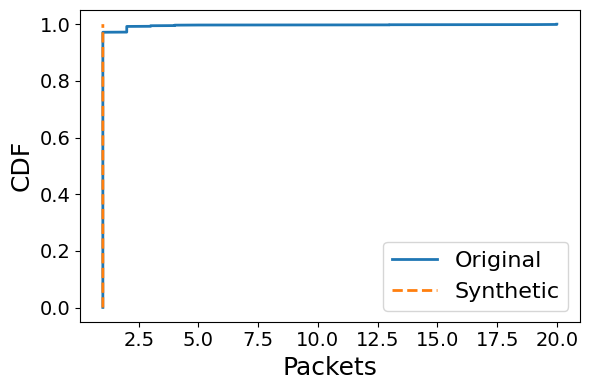

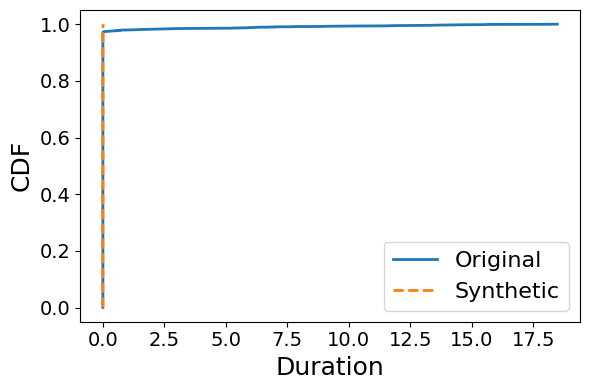

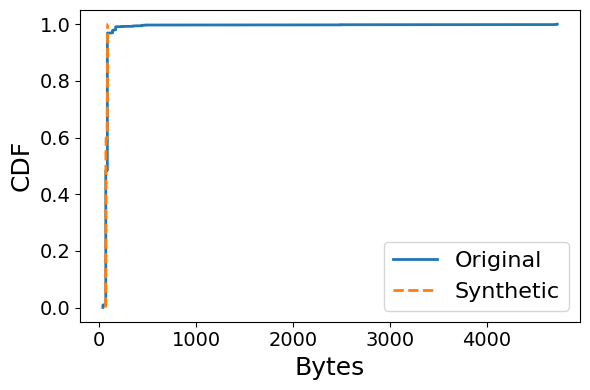

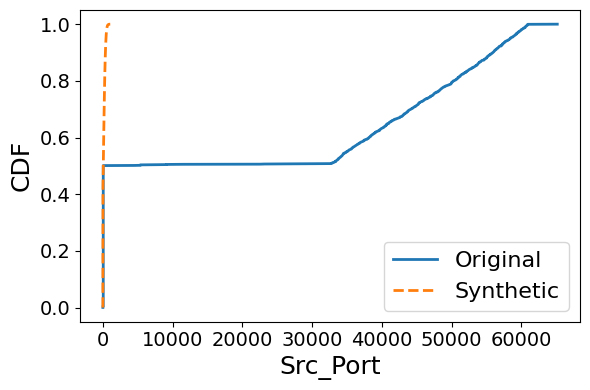

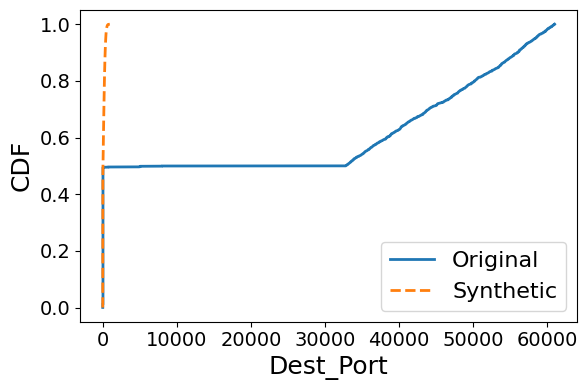

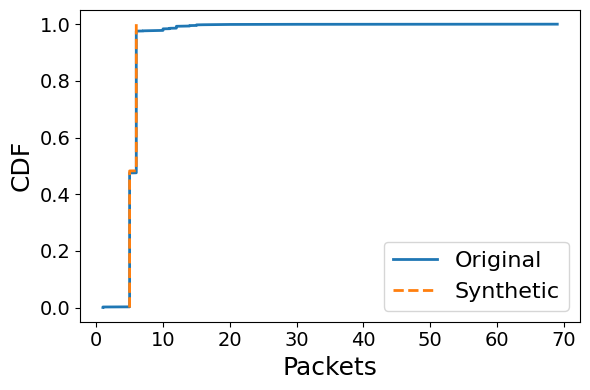

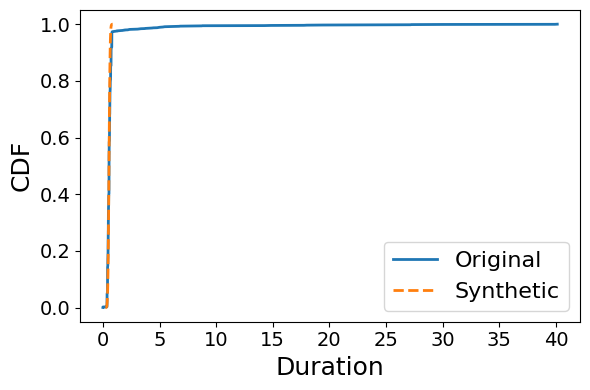

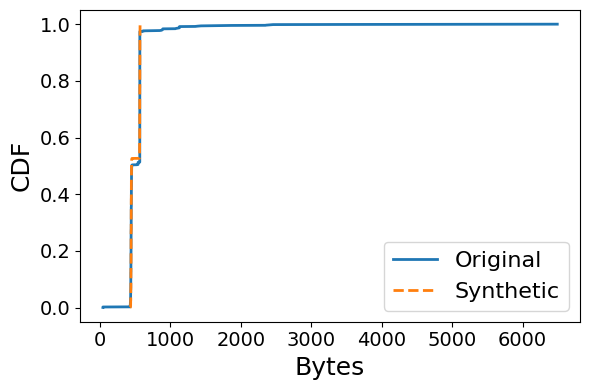

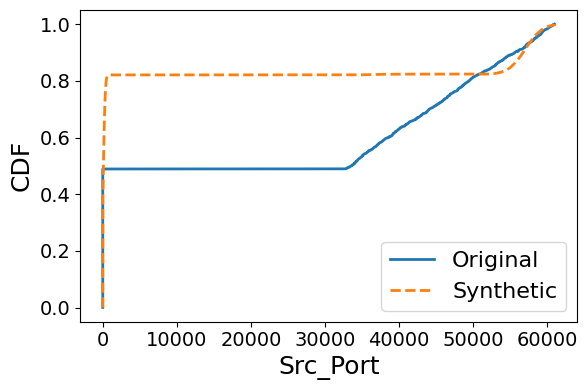

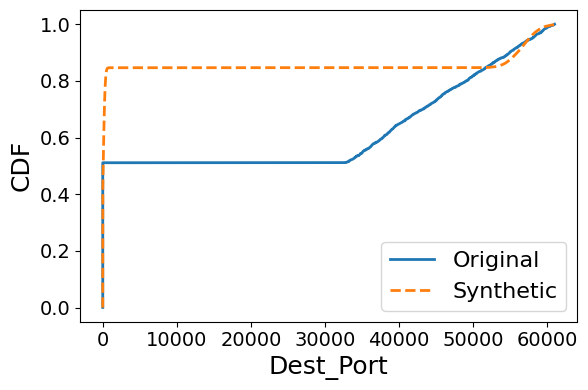

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cdfs(original_df, generated_df, features):
    for feature in features:
        orig_values = np.sort(original_df[feature].dropna())
        gen_values = np.sort(generated_df[feature].dropna())

        orig_cdf = np.arange(1, len(orig_values)+1) / len(orig_values)
        gen_cdf = np.arange(1, len(gen_values)+1) / len(gen_values)

        plt.figure(figsize=(6, 4))
        plt.plot(orig_values, orig_cdf, label='Original', linewidth=2)
        plt.plot(gen_values, gen_cdf, label='Synthetic', linewidth=2, linestyle='--')
        plt.xlabel(feature, fontsize=18)
        plt.ylabel("CDF", fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(fontsize=16)
        plt.tight_layout()
        plt.show()
plot_cdfs(botnet_orig, botnet_gen, selected_features)
plot_cdfs(spam_orig, spam_gen, selected_features)

W2 distance

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import wasserstein_distance
def compute_scaled_wasserstein_distances(df1, df2, features):
    scaler = MinMaxScaler()
    distances = {}

    for feature in features:
        combined = pd.concat([df1[feature], df2[feature]]).values.reshape(-1, 1)
        scaled = scaler.fit_transform(combined).flatten()

        split = len(df1[feature])
        scaled1 = scaled[:split]
        scaled2 = scaled[split:]

        distances[feature] = wasserstein_distance(scaled1, scaled2)

    return distances

w_scaled_botnet = compute_scaled_wasserstein_distances(botnet_orig, botnet_gen, selected_features)
w_scaled_spam = compute_scaled_wasserstein_distances(spam_orig, spam_gen, selected_features)

print("Wasserstein distances (Botnet):")
for k, v in w_scaled_botnet.items():
    print(f"{k}: {v:.4f}")

print("\nWasserstein distances (Spam):")
for k, v in w_scaled_spam.items():
    print(f"{k}: {v:.4f}")

Wasserstein distances (Botnet):
Packets: 0.0044
Duration: 0.0091
Bytes: 0.0037
Src_Port: 0.3569
Dest_Port: 0.3854

Wasserstein distances (Spam):
Packets: 0.0029
Duration: 0.0057
Bytes: 0.0042
Src_Port: 0.2291
Dest_Port: 0.2322


Violin plot

<ipython-input-71-8a0fb3f226ae>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y='Value', data=df_combined, palette='Set2')


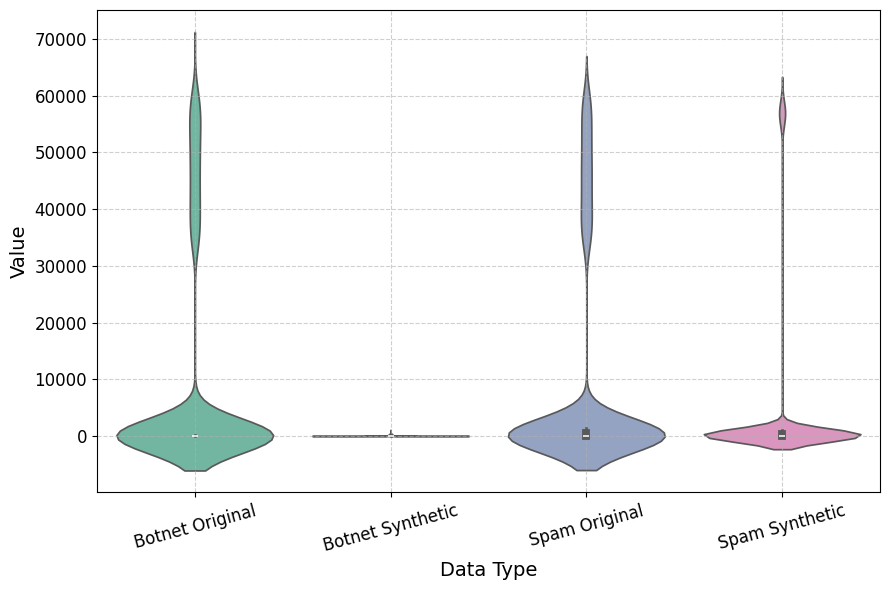

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def combined_violin_plot(botnet_orig, botnet_gen, spam_orig, spam_gen, features):
    data = []
    labels = []

    for label, df in zip(
        ['Botnet Original', 'Botnet Synthetic', 'Spam Original', 'Spam Synthetic'],
        [botnet_orig, botnet_gen, spam_orig, spam_gen]
    ):
        for feature in features:
            data.extend(df[feature].dropna().values)
            labels.extend([label] * df[feature].dropna().shape[0])

    df_combined = pd.DataFrame({'Value': data, 'Type': labels})

    plt.figure(figsize=(9, 6))
    sns.violinplot(x='Type', y='Value', data=df_combined, palette='Set2')

    plt.ylabel("Value", fontsize=14)
    plt.xlabel("Data Type", fontsize=14)
    plt.xticks(rotation=15, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

selected_features = ['Packets', 'Duration', 'Bytes', 'Src_Port', 'Dest_Port']
combined_violin_plot(botnet_orig, botnet_gen, spam_orig, spam_gen, selected_features)


Heatmaps

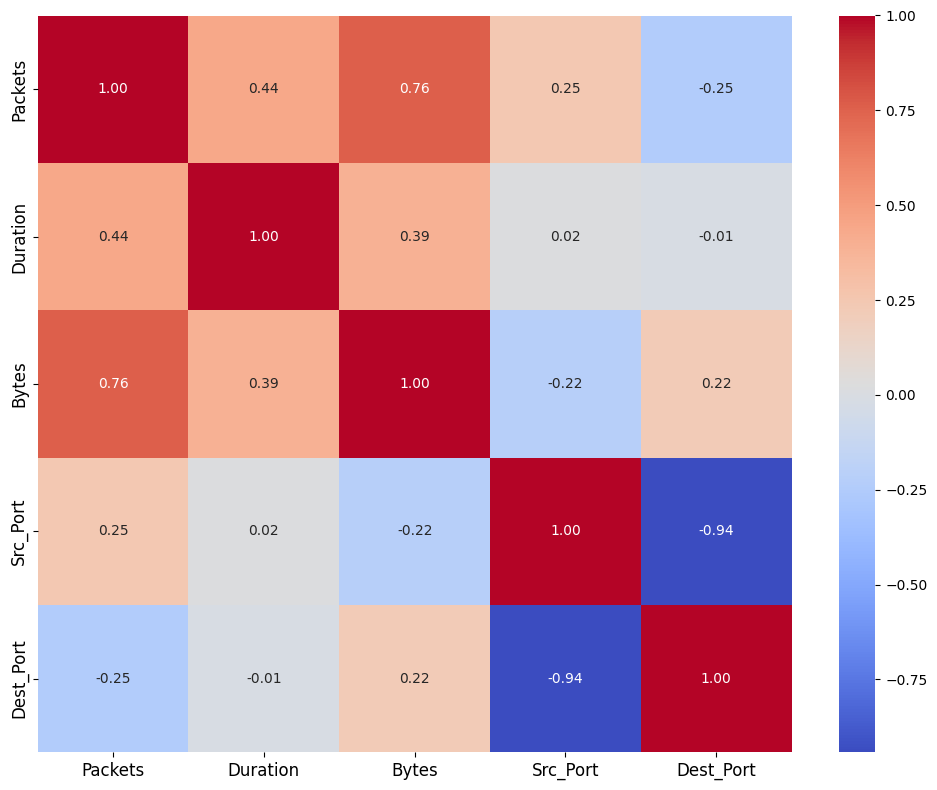

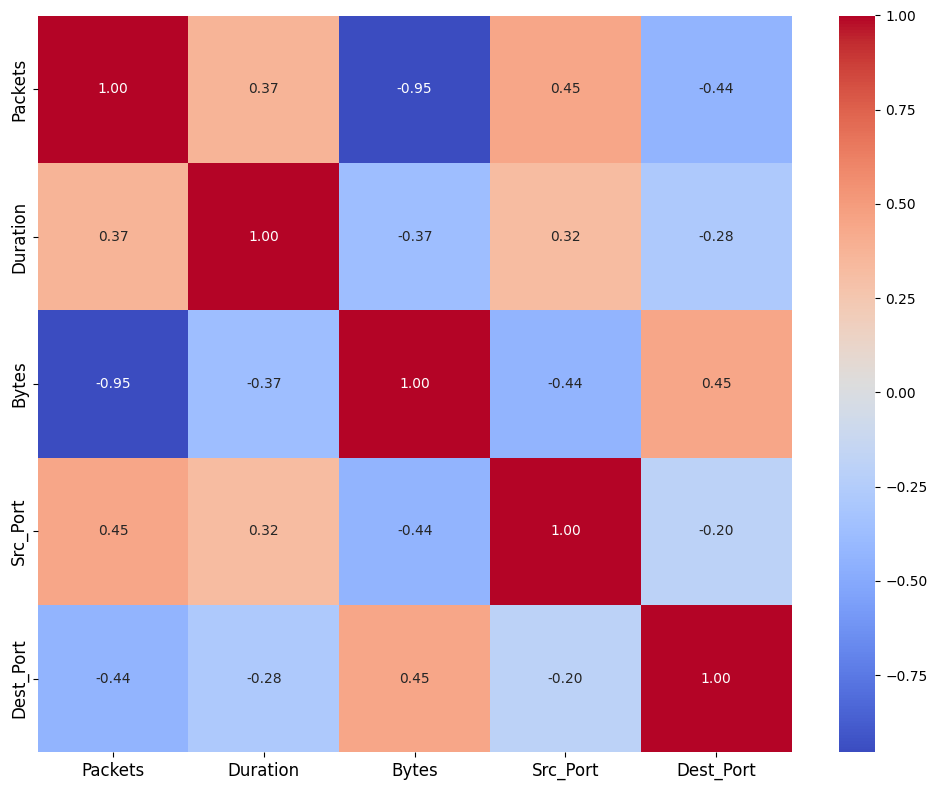

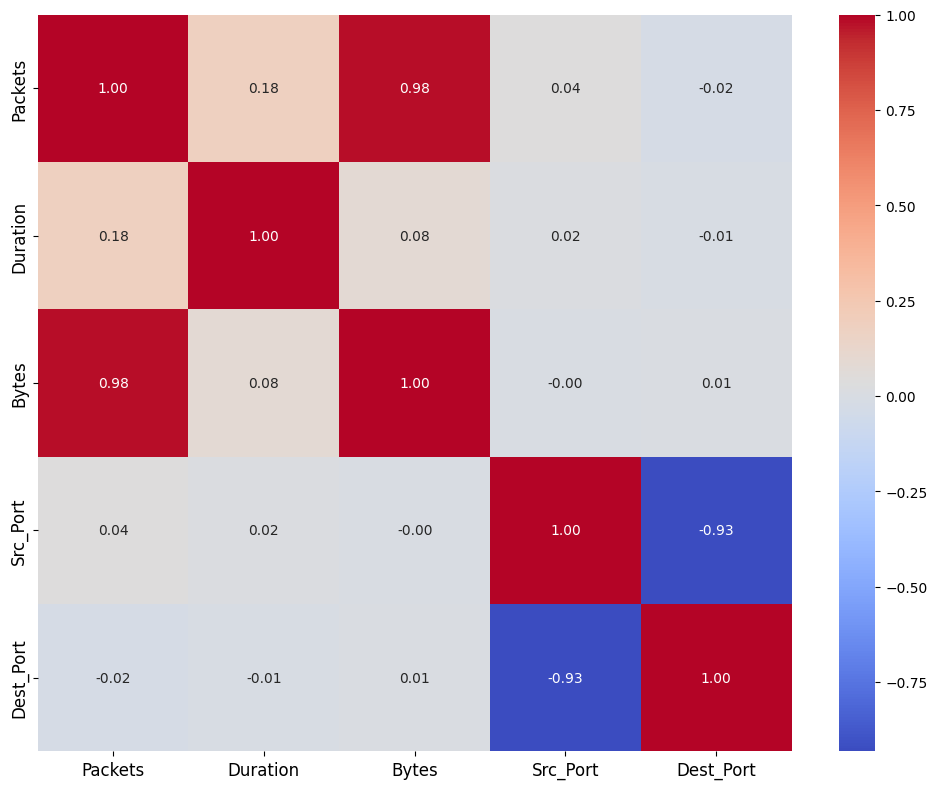

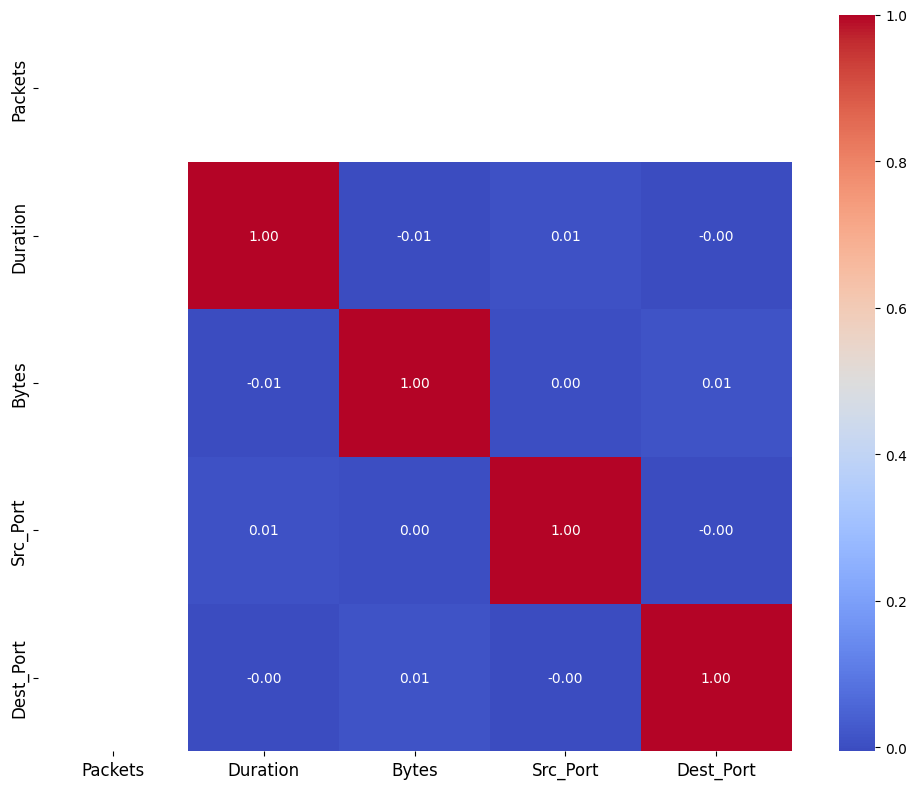

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(data):
    plt.figure(figsize=(10, 8))
    correlation_matrix = data.corr()  # Correlation matrix
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

plot_heatmap(spam_orig[selected_features])
plot_heatmap(spam_gen[selected_features])
plot_heatmap(botnet_orig[selected_features])
plot_heatmap(botnet_gen[selected_features])


In [ ]:
print(spam_gen.columns)
print(selected_features)

Index(['Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS', 'Packets',
       'Bytes', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')
['Packets', 'Duration', 'Bytes', 'Src_Port', 'Dest_Port']


pMSE

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

def compute_pmse(original_df, synthetic_df, features=None, test_size=0.3, random_state=42):
    if features is None:
        features = list(set(original_df.columns) & set(synthetic_df.columns))
        features = [f for f in features if pd.api.types.is_numeric_dtype(original_df[f])]

    original_df = original_df[features].copy()
    synthetic_df = synthetic_df[features].copy()
    original_df['label'] = 0
    synthetic_df['label'] = 1

    #shuffle data
    combined = pd.concat([original_df, synthetic_df], axis=0).sample(frac=1, random_state=random_state).reset_index(drop=True)

    #split into train,test
    X = combined[features]
    y = combined['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Logistic regression Classifier
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    #probabilities
    p_hat = clf.predict_proba(X_test)[:, 1]
    pmse = np.mean((p_hat - 0.5) ** 2)
    return pmse

pmse_botnet = compute_pmse(botnet_orig, botnet_gen)
pmse_spam = compute_pmse(spam_orig, spam_gen)

print(f"pMSE Botnet: {pmse_botnet:.4f}")
print(f"pMSE Spam: {pmse_spam:.4f}")


pMSE Botnet: 0.2500
pMSE Spam: 0.2168


Mahalanobis distance outlier filtering

       Duration  Src_Port  Dest_Port  Protocol  TOS  Packets  Bytes  U  A  P  \
0         0.000        80        166        17    0        1     69  0  1  0   
1         0.004         0        153        17    0        1     70  0  1  0   
2         0.000         0        224        17    0        1     70  0  1  0   
4         0.000         0        418        17    0        1     69  0  1  0   
5         0.004        28        298        17    0        1     71  0  1  0   
...         ...       ...        ...       ...  ...      ...    ... .. .. ..   
52495     0.002       303        226        17    0        1     86  0  1  0   
52496     0.001       110         22        17    0        1     70  0  1  0   
52497     0.000       287         47        17    0        1     71  0  1  0   
52498     0.002         0         39        17    0        1     88  0  1  0   
52499     0.001         0         22        17    0        1     85  0  1  0   

       R  S  F  Class  
0      0  0  0 

(array([2.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 6.000e+00,
        9.000e+00, 1.700e+01, 8.000e+00, 1.900e+01, 2.900e+01, 4.700e+01,
        4.400e+01, 6.100e+01, 1.030e+02, 1.160e+02, 1.420e+02, 1.880e+02,
        2.450e+02, 3.080e+02, 3.950e+02, 4.910e+02, 5.860e+02, 6.920e+02,
        8.320e+02, 9.850e+02, 1.151e+03, 1.272e+03, 1.469e+03, 1.616e+03,
        1.951e+03, 2.147e+03, 2.187e+03, 2.301e+03, 2.512e+03, 2.628e+03,
        5.012e+03, 2.822e+03, 1.776e+03, 1.810e+03, 1.994e+03, 1.972e+03,
        2.001e+03, 2.399e+03, 2.954e+03, 2.984e+03, 1.678e+03, 4.580e+02,
        6.800e+01, 4.000e+00]),
 array([5.33396585, 5.33825076, 5.34253568, 5.34682059, 5.35110551,
        5.35539043, 5.35967534, 5.36396026, 5.36824517, 5.37253009,
        5.376815  , 5.38109992, 5.38538483, 5.38966975, 5.39395467,
        5.39823958, 5.4025245 , 5.40680941, 5.41109433, 5.41537924,
        5.41966416, 5.42394907, 5.42823399, 5.4325189 , 5.43680382,
        5.44108874, 5.44537365, 5.44

Text(0.5, 1.0, 'Mahalanobis Distance of Synthetic Samples')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Frequency')

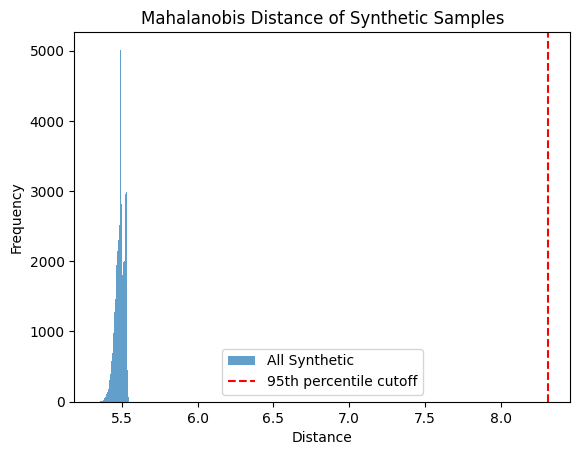

In [ ]:

from scipy.spatial import distance
import numpy as np

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_real_botnet_scaled = scaler.fit_transform(botnet_orig)
X_synth_botnet_scaled = scaler.transform(botnet_gen)

X_real_spam_scaled = scaler.fit_transform(spam_orig)
X_synth_spam_scaled = scaler.transform(spam_gen)


#botnet
mu = np.mean(X_real_botnet_scaled, axis=0)
cov = np.cov(X_real_botnet_scaled, rowvar=False)
inv_covmat = np.linalg.pinv(cov)

distances = [distance.mahalanobis(x, mu, inv_covmat) for x in X_synth_botnet_scaled]

#spam
mu = np.mean(X_real_spam_scaled, axis=0)
cov = np.cov(X_real_spam_scaled, rowvar=False)
inv_covmat = np.linalg.pinv(cov)

distances_spam = [distance.mahalanobis(x, mu, inv_covmat) for x in X_synth_spam_scaled]

# Keep samples within a threshold (e.g., 95th percentile)
threshold = np.percentile(distances, 95)
filtered_X_botnet_synth = botnet_gen[np.array(distances) < threshold]

# Keep samples within a threshold (e.g., 95th percentile)
threshold = np.percentile(distances_spam, 95)
filtered_X_spam_synth = spam_gen[np.array(distances_spam) < threshold]

print(filtered_X_botnet_synth)
print("Original synthetic samples botnet:", len(X_synth_botnet_scaled))
print("After filtering:", filtered_X_botnet_synth.shape[0])
print("Removed samples:", len(X_synth_botnet_scaled) - filtered_X_botnet_synth.shape[0])

print("Original synthetic samples spam:", len(X_synth_spam_scaled))
print("After filtering:", filtered_X_spam_synth.shape[0])
print("Removed samples:", len(X_synth_spam_scaled) - filtered_X_spam_synth.shape[0])

import matplotlib.pyplot as plt

plt.hist(distances, bins=50, alpha=0.7, label='All Synthetic')
plt.axvline(threshold, color='red', linestyle='--', label='95th percentile cutoff')
plt.title("Mahalanobis Distance of Synthetic Samples")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import pandas as pd
import numpy as np

X = dfaugust.drop(columns=['Class'])
y = dfaugust['Class']

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


filtered_X_botnet_synth = filtered_X_botnet_synth.drop(columns='Class', errors='ignore')
filtered_X_spam_synth = filtered_X_spam_synth.drop(columns='Class', errors='ignore')

X_train = pd.concat([X_train_orig, filtered_X_botnet_synth, filtered_X_spam_synth], ignore_index=True)

y_train = pd.concat([
    y_train_orig,
    pd.Series([2] * len(filtered_X_botnet_synth)),
    pd.Series([4] * len(filtered_X_spam_synth))
], ignore_index=True)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_train, y_train = shuffle(X_train, y_train, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Label distribution in training set:\n", y_train.value_counts())

mlp_classifier.fit(X_train, y_train)
y_pred_mlp = mlp_classifier.predict(X_test)

#Map
class_labels = {0: 'Benign', 1: 'DoS', 2: 'Botnet', 3: 'Scan44', 4: 'Spam'}
y_test_class = y_test.map(class_labels)
y_pred_mlp_class = pd.Series(y_pred_mlp).map(class_labels)

print("=== MLP Classification Report ===")
print(classification_report(y_test_class, y_pred_mlp_class))

# confusion matrix
cm = confusion_matrix(y_test_class, y_pred_mlp_class)
print("\nConfusion Matrix:\n", cm)

fpr_dict = {}
fnr_dict = {}
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FP - FN

    fnr_dict[i] = FN / (FN + TP) if (FN + TP) > 0 else 0
    fpr_dict[i] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nFalse Negative Rate (FNR) per class:")
for k, v in fnr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

print("\nFalse Positive Rate (FPR) per class:")
for k, v in fpr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

y_proba = mlp_classifier.predict_proba(X_test)


from sklearn.preprocessing import label_binarize
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

# PRAUC per class
prauc_dict = {}
for i in range(len(classes)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    prauc = auc(recall, precision)
    prauc_dict[class_labels[i]] = prauc

print("\nPrecision-Recall AUC (PRAUC) per class:")
for k, v in prauc_dict.items():
    print(f"Class {k}: {v:.4f}")


Label distribution in training set:
 4    51275
2    50350
0    21000
1    12250
3    12250
Name: count, dtype: int64


MLPClassifier(hidden_layer_sizes=(100, 100))

=== MLP Classification Report ===
              precision    recall  f1-score   support

      Benign       0.93      0.97      0.95      9000
      Botnet       0.07      0.01      0.01       600
         DoS       1.00      1.00      1.00      5250
      Scan44       0.98      1.00      0.99      5250
        Spam       0.81      0.97      0.88       600

    accuracy                           0.96     20700
   macro avg       0.76      0.79      0.77     20700
weighted avg       0.93      0.96      0.94     20700


Confusion Matrix:
 [[8721   41    4  100  134]
 [ 594    3    0    3    0]
 [   0    0 5250    0    0]
 [   7    0    0 5243    0]
 [  19    0    0    0  581]]

False Negative Rate (FNR) per class:
Class Benign: 0.0310
Class DoS: 0.9950
Class Botnet: 0.0000
Class Scan44: 0.0013
Class Spam: 0.0317

False Positive Rate (FPR) per class:
Class Benign: 0.0530
Class DoS: 0.0020
Class Botnet: 0.0003
Class Scan44: 0.0067
Class Spam: 0.0067

Precision-Recall AUC (PRAUC) per class:

In [ ]:
filtered_X_botnet_md= filtered_X_botnet_synth
filtered_X_spam_md = filtered_X_spam_synth

In [ ]:
filtered_X_botnet_synth.to_csv('TVAE_MD_botnet_August.csv', index=False)
filtered_X_spam_synth.to_csv('TVAE_MD_spam_August.csv', index=False)

In [ ]:
print(len(X_real_spam_scaled))

2000


In [ ]:
len(X_synth_spam_scaled)

52500

t-SNE graphs

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


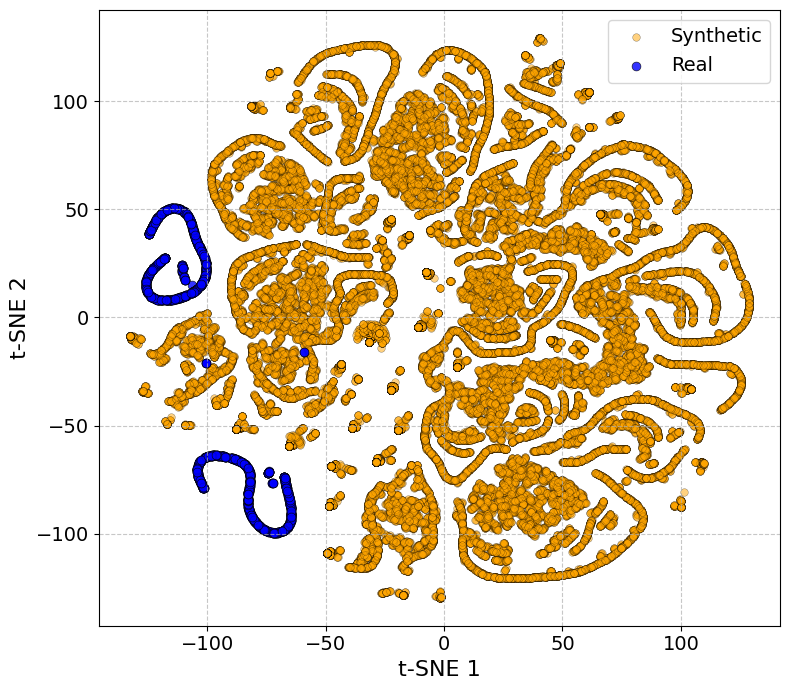

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


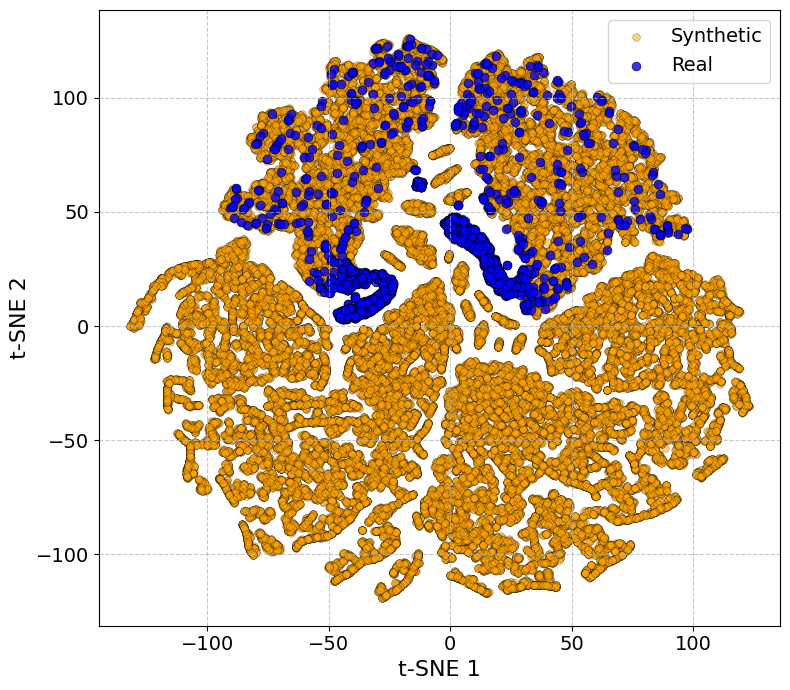

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne(real_scaled, synth_scaled, title):
    combined = np.vstack([real_scaled, synth_scaled])
    labels = np.array([0] * len(real_scaled) + [1] * len(synth_scaled))

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    tsne_results = tsne.fit_transform(combined)

    plt.figure(figsize=(8, 7))

    #Synthetic
    plt.scatter(tsne_results[labels == 1, 0], tsne_results[labels == 1, 1],
                c='orange', label='Synthetic', alpha=0.5, s=30,
                edgecolors='k', linewidths=0.3)

    #Real
    plt.scatter(tsne_results[labels == 0, 0], tsne_results[labels == 0, 1],
                c='blue', label='Real', alpha=0.8, s=40,
                edgecolors='k', linewidths=0.5)

    plt.legend(fontsize=14)
    plt.xlabel("t-SNE 1", fontsize=16)
    plt.ylabel("t-SNE 2", fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)  # Tick labels
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


plot_tsne(X_real_botnet_scaled, X_synth_botnet_scaled, "Botnet")
plot_tsne(X_real_spam_scaled, X_synth_spam_scaled, "Spam")


One class- SVM

In [ ]:
from sklearn.svm import OneClassSVM


ocsvm_botnet = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')  # nu=0.05 allows ~5% outliers
ocsvm_botnet.fit(X_real_botnet_scaled)
scores_botnet = ocsvm_botnet.predict(X_synth_botnet_scaled)  # -1 for outlier, 1 for inlier
filtered_ocsvm_botnet = botnet_gen[np.array(scores_botnet) == 1]

ocsvm_spam = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
ocsvm_spam.fit(X_real_spam_scaled)
scores_spam = ocsvm_spam.predict(X_synth_spam_scaled)
filtered_ocsvm_spam = spam_gen[np.array(scores_spam) == 1]

print("Botnet - OC-SVM accepted:", filtered_ocsvm_botnet.shape[0])
print("Spam - OC-SVM accepted:", filtered_ocsvm_spam.shape[0])



OneClassSVM(nu=0.05)

OneClassSVM(nu=0.05)

Botnet - OC-SVM accepted: 0
Spam - OC-SVM accepted: 16798


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import pandas as pd
import numpy as np

X = dfaugust.drop(columns=['Class'])
y = dfaugust['Class'].astype(int)

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

filtered_ocsvm_botnet = filtered_ocsvm_botnet.drop(columns='Class', errors='ignore')
filtered_ocsvm_spam = filtered_ocsvm_spam.drop(columns='Class', errors='ignore')

X_train = pd.concat([X_train_orig, filtered_ocsvm_botnet, filtered_ocsvm_spam], ignore_index=True)
y_train = pd.concat([y_train_orig, pd.Series([2] * len(filtered_ocsvm_botnet)), pd.Series([4] * len(filtered_ocsvm_spam))], ignore_index=True)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_train, y_train = shuffle(X_train, y_train, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
mlp_classifier = MLPClassifier(random_state=42)
mlp_classifier.fit(X_train_scaled, y_train)
y_pred = mlp_classifier.predict(X_test_scaled)

class_labels = {0: 'Benign', 1: 'DoS', 2: 'Botnet', 3: 'Scan', 4: 'Spam'}

print("=== MLP Classification Report (OC-SVM filtered data) ===")
y_test_class = y_test.map(class_labels)
y_pred_class = pd.Series(y_pred).map(class_labels)
print(classification_report(y_test_class, y_pred_class))

cm = confusion_matrix(y_test_class, y_pred_class)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=[class_labels[i] for i in range(len(class_labels))], columns=[class_labels[i] for i in range(len(class_labels))]))

fpr_dict = {}
fnr_dict = {}
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FP - FN

    fnr_dict[i] = FN / (FN + TP) if (FN + TP) > 0 else 0
    fpr_dict[i] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nFalse Negative Rate (FNR) per class:")
for k, v in fnr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

print("\nFalse Positive Rate (FPR) per class:")
for k, v in fpr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

#probabilities
y_proba = mlp_classifier.predict_proba(X_test_scaled)
from sklearn.preprocessing import label_binarize
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

# per class PRAUC
prauc_dict = {}
for i in range(len(classes)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    prauc = auc(recall, precision)
    prauc_dict[class_labels[i]] = prauc

print("\nPrecision-Recall AUC (PRAUC) per class:")
for k, v in prauc_dict.items():
    print(f"Class {k}: {v:.4f}")


<ipython-input-83-00fafb0d975d>:20: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_train = pd.concat([y_train_orig, pd.Series([2] * len(filtered_ocsvm_botnet)), pd.Series([4] * len(filtered_ocsvm_spam))], ignore_index=True)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

=== MLP Classification Report (OC-SVM filtered data) ===
              precision    recall  f1-score   support

      Benign       0.93      0.97      0.95      9000
      Botnet       0.25      0.00      0.01       600
         DoS       1.00      1.00      1.00      5250
        Scan       0.98      1.00      0.99      5250
        Spam       0.76      0.97      0.86       600

    accuracy                           0.96     20700
   macro avg       0.79      0.79      0.76     20700
weighted avg       0.94      0.96      0.94     20700


Confusion Matrix:
        Benign  DoS  Botnet  Scan  Spam
Benign    8713    6       8    90   183
DoS        595    2       0     3     0
Botnet       0    0    5250     0     0
Scan         7    0       0  5243     0
Spam        15    0       0     0   585

False Negative Rate (FNR) per class:
Class Benign: 0.0319
Class DoS: 0.9967
Class Botnet: 0.0000
Class Scan: 0.0013
Class Spam: 0.0250

False Positive Rate (FPR) per class:
Class Benign: 0.0527


In [ ]:
filtered_ocsvm_botnet.to_csv("TVAE_OCSVM_botnet_August.csv", index=False)
filtered_ocsvm_spam.to_csv('TVAE_OCSVM_spam_August.csv', index=False)

kNN

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

knn_botnet = NearestNeighbors(n_neighbors=5)
knn_botnet.fit(X_real_botnet_scaled)
distances_knn_botnet, _ = knn_botnet.kneighbors(X_synth_botnet_scaled)
avg_knn_dist_botnet = distances_knn_botnet.mean(axis=1)
threshold_knn_botnet = np.percentile(avg_knn_dist_botnet, 95)
filtered_knn_botnet = botnet_gen[np.array(avg_knn_dist_botnet) < threshold_knn_botnet]

knn_spam = NearestNeighbors(n_neighbors=5)
knn_spam.fit(X_real_spam_scaled)
distances_knn_spam, _ = knn_spam.kneighbors(X_synth_spam_scaled)
avg_knn_dist_spam = distances_knn_spam.mean(axis=1)
threshold_knn_spam = np.percentile(avg_knn_dist_spam, 95)
filtered_knn_spam = spam_gen[np.array(avg_knn_dist_spam) < threshold_knn_spam]

print("Botnet - kNN accepted:", filtered_knn_botnet.shape[0])
print("Spam - kNN accepted:", filtered_knn_spam.shape[0])


NearestNeighbors()

NearestNeighbors()

Botnet - kNN accepted: 49859
Spam - kNN accepted: 49874


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc
)
import numpy as np
import pandas as pd

X = dfaugust.drop(columns=['Class'])
y = dfaugust['Class'].astype(int)

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

filtered_knn_botnet = filtered_knn_botnet.drop(columns='Class', errors='ignore')
filtered_knn_spam = filtered_knn_spam.drop(columns='Class', errors='ignore')
#append to original train
X_train = pd.concat([X_train_orig, filtered_knn_botnet, filtered_knn_spam], ignore_index=True)
y_train = pd.concat([y_train_orig,
    pd.Series([2] * len(filtered_knn_botnet)),
    pd.Series([4] * len(filtered_knn_spam)),
], ignore_index=True)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_train, y_train = shuffle(X_train, y_train, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_classifier.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_classifier.predict(X_test_scaled)
y_proba = mlp_classifier.predict_proba(X_test_scaled)

class_labels = {0: 'Benign', 1: 'DoS', 2: 'Botnet', 3: 'Scan', 4: 'Spam'}

print("=== MLP Classification Report ===")
y_test_class = y_test.map(class_labels)
y_pred_class = pd.Series(y_pred_mlp).map(class_labels)
print(classification_report(y_test_class, y_pred_class))
cm = confusion_matrix(y_test_class, y_pred_class)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=[class_labels[i] for i in range(len(class_labels))], columns=[class_labels[i] for i in range(len(class_labels))]))

fpr_dict = {}
fnr_dict = {}

for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FP - FN

    fnr_dict[i] = FN / (FN + TP) if (FN + TP) > 0 else 0
    fpr_dict[i] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nFalse Negative Rate (FNR) per class:")
for k, v in fnr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

print("\nFalse Positive Rate (FPR) per class:")
for k, v in fpr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

y_test_bin = label_binarize(y_test, classes=np.unique(y))
prauc_dict = {}
for i in range(len(class_labels)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    prauc = auc(recall, precision)
    prauc_dict[class_labels[i]] = prauc

print("\nPrecision-Recall AUC (PRAUC) per class:")
for k, v in prauc_dict.items():
    print(f"Class {k}: {v:.4f}")


MLPClassifier(max_iter=300, random_state=42)

=== MLP Classification Report ===
              precision    recall  f1-score   support

      Benign       0.93      0.97      0.95      9000
      Botnet       0.05      0.00      0.01       600
         DoS       1.00      1.00      1.00      5250
        Scan       0.98      1.00      0.99      5250
        Spam       0.80      0.97      0.88       600

    accuracy                           0.96     20700
   macro avg       0.75      0.79      0.76     20700
weighted avg       0.93      0.96      0.94     20700


Confusion Matrix:
        Benign  DoS  Botnet  Scan  Spam
Benign    8720   38       5    89   148
DoS        595    2       0     3     0
Botnet      21    0    5229     0     0
Scan         8    0       0  5242     0
Spam        17    0       0     0   583

False Negative Rate (FNR) per class:
Class Benign: 0.0311
Class DoS: 0.9967
Class Botnet: 0.0040
Class Scan: 0.0015
Class Spam: 0.0283

False Positive Rate (FPR) per class:
Class Benign: 0.0548
Class DoS: 0.0019
Class

In [ ]:
filtered_knn_botnet.to_csv('TVAE_knn_botnet_August.csv', index=False)
filtered_knn_spam.to_csv('TVAE_knn_spam_August.csv', index=False)

Cosine similarity

Original synthetic samples botnet: 52500
After filtering: 0
Removed samples: 52500
Original synthetic samples spam: 52500
After filtering: 17470
Removed samples: 35030


(array([1.530e+02, 1.164e+03, 1.432e+03, 1.798e+03, 3.656e+03, 3.711e+03,
        2.756e+03, 2.677e+03, 2.616e+03, 2.552e+03, 2.568e+03, 6.170e+03,
        3.923e+03, 2.023e+03, 1.877e+03, 1.756e+03, 1.609e+03, 1.504e+03,
        1.369e+03, 1.159e+03, 1.029e+03, 8.540e+02, 7.510e+02, 6.620e+02,
        5.070e+02, 4.550e+02, 3.770e+02, 3.160e+02, 2.350e+02, 2.090e+02,
        1.430e+02, 1.230e+02, 9.800e+01, 7.800e+01, 4.900e+01, 3.200e+01,
        2.600e+01, 2.800e+01, 2.100e+01, 1.000e+01, 6.000e+00, 6.000e+00,
        4.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.43176413, 0.43229884, 0.43283355, 0.43336826, 0.43390297,
        0.43443768, 0.43497239, 0.4355071 , 0.4360418 , 0.43657651,
        0.43711122, 0.43764593, 0.43818064, 0.43871535, 0.43925006,
        0.43978477, 0.44031948, 0.44085419, 0.44138889, 0.4419236 ,
        0.44245831, 0.44299302, 0.44352773, 0.44406244, 0.44459715,
        0.44513186, 0.44566657, 0.44

Text(0.5, 1.0, 'Cosine Similarity of Synthetic Botnet Samples')

Text(0.5, 0, 'Cosine Similarity')

Text(0, 0.5, 'Frequency')

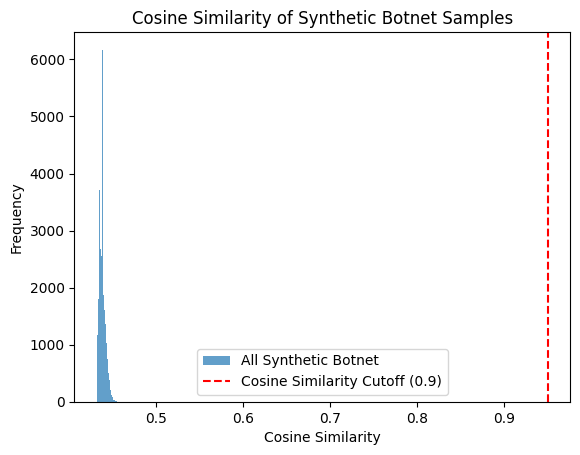

(array([3.3400e+02, 2.2700e+02, 2.4200e+02, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 3.2000e+01, 1.0000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.6000e+01,
        5.2000e+01, 2.6100e+02, 2.4300e+02, 4.3200e+02, 1.7030e+04,
        1.6117e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7470e+04]),
 array([0.17464658, 0.19115365, 0.20766072, 0.22416779, 0.24067485,
        0.25718192, 0.27368899, 0.29019606, 0.30670313, 0.3232102 ,
        0.33971726, 0.35622433, 0.3727314 , 0.38923847, 0.40574554,
        0.42225261, 0.43875967, 0.45526674, 0.47177381, 0.48828088,
        0.50478795, 0.52129502, 0.53780208, 0.

Text(0.5, 1.0, 'Cosine Similarity of Synthetic Spam Samples')

Text(0.5, 0, 'Cosine Similarity')

Text(0, 0.5, 'Frequency')

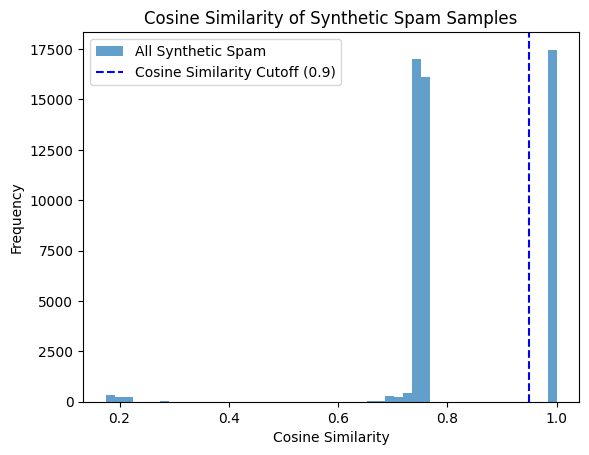

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

X_real_botnet_scaled = scaler.fit_transform(botnet_orig)
X_synth_botnet_scaled = scaler.transform(botnet_gen)

X_real_spam_scaled = scaler.fit_transform(spam_orig)
X_synth_spam_scaled = scaler.transform(spam_gen)

cos_sim_botnet = cosine_similarity(X_synth_botnet_scaled, X_real_botnet_scaled).max(axis=1)
cos_sim_spam = cosine_similarity(X_synth_spam_scaled, X_real_spam_scaled).max(axis=1)

threshold_botnet = 0.95
filtered_X_botnet_synth = botnet_gen[cos_sim_botnet > threshold_botnet]
threshold_spam = 0.95
filtered_X_spam_synth = spam_gen[cos_sim_spam > threshold_spam]

print("Original synthetic samples botnet:", len(X_synth_botnet_scaled))
print("After filtering:", filtered_X_botnet_synth.shape[0])
print("Removed samples:", len(X_synth_botnet_scaled) - filtered_X_botnet_synth.shape[0])

print("Original synthetic samples spam:", len(X_synth_spam_scaled))
print("After filtering:", filtered_X_spam_synth.shape[0])
print("Removed samples:", len(X_synth_spam_scaled) - filtered_X_spam_synth.shape[0])

# visualize
plt.hist(cos_sim_botnet, bins=50, alpha=0.7, label='All Synthetic Botnet')
plt.axvline(threshold_botnet, color='red', linestyle='--', label='Cosine Similarity Cutoff (0.9)')
plt.title("Cosine Similarity of Synthetic Botnet Samples")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

plt.hist(cos_sim_spam, bins=50, alpha=0.7, label='All Synthetic Spam')
plt.axvline(threshold_spam, color='blue', linestyle='--', label='Cosine Similarity Cutoff (0.9)')
plt.title("Cosine Similarity of Synthetic Spam Samples")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

class_names = {0: 'Benign', 1: 'DoS', 2: 'Botnet', 3: 'Scan', 4: 'Spam'}
X = dfaugust.drop(columns=['Class'])
y = dfaugust['Class'].astype(int)

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

filtered_X_botnet_synth = filtered_X_botnet_synth.drop(columns='Class', errors='ignore')
filtered_X_spam_synth = filtered_X_spam_synth.drop(columns='Class', errors='ignore')
X_train = pd.concat([X_train_orig, filtered_X_botnet_synth], ignore_index=True)
X_train = pd.concat([X_train, filtered_X_spam_synth], ignore_index=True)


y_train = pd.concat([y_train_orig, pd.Series([2] * len(filtered_X_botnet_synth))], ignore_index=True)
y_train = pd.concat([y_train, pd.Series([4] * len(filtered_X_spam_synth))], ignore_index=True)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test = X_test[X_train.columns]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Label distribution in training set:\n", y_train.value_counts())

#fit
mlp_classifier = MLPClassifier(random_state=42)
mlp_classifier.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_classifier.predict(X_test_scaled)
print("=== MLP Classification Report ===")
print(classification_report(y_test, y_pred_mlp))
cm = confusion_matrix(y_test, y_pred_mlp)
print("\nConfusion Matrix:")
cm_df = pd.DataFrame(cm, index=[class_names[i] for i in range(len(class_names))],
                     columns=[class_names[i] for i in range(len(class_names))])
print(cm_df)
fpr_dict = {}
fnr_dict = {}
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FP - FN

    fnr_dict[i] = FN / (FN + TP) if (FN + TP) > 0 else 0
    fpr_dict[i] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nFalse Negative Rate (FNR) per class:")
for k, v in fnr_dict.items():
    print(f"{class_names[k]}: {v:.4f}")

print("\nFalse Positive Rate (FPR) per class:")
for k, v in fpr_dict.items():
    print(f"{class_names[k]}: {v:.4f}")
y_proba = mlp_classifier.predict_proba(X_test_scaled)
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)
prauc_dict = {}
for i in range(len(classes)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    prauc = auc(recall, precision)
    prauc_dict[classes[i]] = prauc

print("\nPrecision-Recall AUC (PRAUC) per class:")
for k, v in prauc_dict.items():
    print(f"{class_names[k]}: {v:.4f}")


<ipython-input-89-e0b0d7910b97>:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_train = pd.concat([y_train_orig, pd.Series([2] * len(filtered_X_botnet_synth))], ignore_index=True)


Label distribution in training set:
 0    21000
4    18870
1    12250
3    12250
2     1400
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

=== MLP Classification Report ===
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      9000
           1       1.00      1.00      1.00      5250
           2       0.40      0.00      0.01       600
           3       0.98      1.00      0.99      5250
           4       0.79      0.97      0.87       600

    accuracy                           0.96     20700
   macro avg       0.82      0.79      0.76     20700
weighted avg       0.94      0.96      0.94     20700


Confusion Matrix:
        Benign   DoS  Botnet  Scan  Spam
Benign    8736     8       3    95   158
DoS          0  5250       0     0     0
Botnet     595     0       2     3     0
Scan         7     0       0  5243     0
Spam        16     0       0     0   584

False Negative Rate (FNR) per class:
Benign: 0.0293
DoS: 0.0000
Botnet: 0.9967
Scan: 0.0013
Spam: 0.0267

False Positive Rate (FPR) per class:
Benign: 0.0528
DoS: 0.0005
Botnet: 0.0001
Scan: 0.0063
Spam: 0.0079


In [ ]:
filtered_X_botnet_synth.to_csv('TVAE_cosine_botnet_August.csv', index=False)
filtered_X_spam_synth.to_csv('TVAE_cosine_spam_August.csv', index=False)